In [ ]:
#!git clone https://huggingface.co/datasets/PaulLerner/viquae_all_images

In [2]:
!git clone https://huggingface.co/datasets/PaulLerner/viquae_images

fatal: destination path 'viquae_images' already exists and is not an empty directory.


In [14]:
!git clone https://huggingface.co/datasets/PaulLerner/viquae_dataset

Cloning into 'viquae_dataset'...
Updating files:  80% (4/5)
Updating files: 100% (5/5)
Updating files: 100% (5/5), done.
Filtering content:  66% (2/3)
Filtering content: 100% (3/3)
Filtering content: 100% (3/3), 8.26 MiB | 1.82 MiB/s, done.


In [4]:
!git clone https://huggingface.co/datasets/PaulLerner/viquae_wikipedia

fatal: destination path 'viquae_wikipedia' already exists and is not an empty directory.


In [4]:
from datasets import load_dataset
dataset = load_dataset('PaulLerner/viquae_dataset')
dataset

C:\Python310\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


DatasetDict({
    train: Dataset({
        features: ['image', 'input', 'kilt_id', 'id', 'meta', 'original_question', 'output', 'url', 'wikidata_id'],
        num_rows: 1190
    })
    validation: Dataset({
        features: ['image', 'input', 'kilt_id', 'id', 'meta', 'original_question', 'output', 'url', 'wikidata_id'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['image', 'input', 'kilt_id', 'id', 'meta', 'original_question', 'output', 'url', 'wikidata_id'],
        num_rows: 1257
    })
})

In [15]:
# save the dataset to a file
dataset.save_to_disk('data/viquae_dataset')

Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1257/1257 [00:00<00:00, 114651.30 examples/s]


In [5]:
item = dataset['test'][0]

In [6]:
type(item)

dict

In [7]:
item['url']

'http://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Jackie_Wilson.png/512px-Jackie_Wilson.png'

In [8]:
item['image']

'512px-Jackie_Wilson.png'

In [9]:
# import os
# os.environ['VIQUAE_IMAGES_PATH']='viquae_images/images'

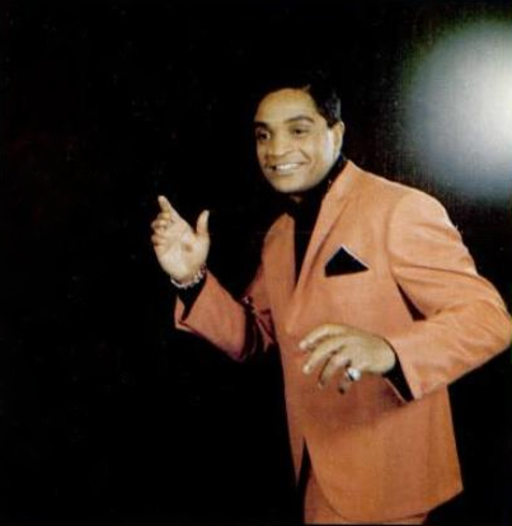

In [9]:
from meerqat.data.loading import load_image
load_image(item['image'])

In [10]:
from meerqat.data.loading import load_image_batch
image = load_image_batch([item['image']])[0]
type(image), image.size

(PIL.Image.Image, (512, 526))

In [19]:
item['input']

"this singer's re-issued song became the UK Christmas number one after helping to advertise what brand?"

In [20]:
item['output']['original_answer']

"Levi's"

In [21]:
data_files = dict(
    humans_with_faces='humans_with_faces.jsonl.gz',
    humans_without_faces='humans_without_faces.jsonl.gz',
    non_humans='non_humans.jsonl.gz'
)
kb = load_dataset('PaulLerner/viquae_wikipedia', data_files=data_files)
kb

C:\Python310\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Generating humans_with_faces split: 506237 examples [01:07, 7547.58 examples/s]
Generating humans_without_faces split: 35736 examples [00:03, 9245.96 examples/s] 
Generating non_humans split: 953379 examples [01:43, 9195.79 examples/s] 


DatasetDict({
    humans_with_faces: Dataset({
        features: ['anchors', 'categories', 'image', 'kilt_id', 'text', 'url', 'wikidata_info', 'wikipedia_id', 'wikipedia_title'],
        num_rows: 506237
    })
    humans_without_faces: Dataset({
        features: ['anchors', 'categories', 'image', 'kilt_id', 'text', 'url', 'wikidata_info', 'wikipedia_id', 'wikipedia_title'],
        num_rows: 35736
    })
    non_humans: Dataset({
        features: ['anchors', 'categories', 'image', 'kilt_id', 'text', 'url', 'wikidata_info', 'wikipedia_id', 'wikipedia_title'],
        num_rows: 953379
    })
})

In [22]:
item = kb['humans_with_faces'][0]
item['wikidata_info']['wikidata_id'], item['wikidata_info']['wikipedia_title']

('Q313590', 'Alain Connes')

In [23]:
item['image']

'512px-Alain_Connes.jpg'

In [24]:
# the text is stored in a list of string, one per paragraph
type(item['text']['paragraph']), len(item['text']['paragraph'])

(list, 25)

In [25]:
# the text is stored in a list of string, one per paragraph
item['text']['paragraph'][1]

'Alain Connes (; born 1 April 1947) is a French mathematician, currently Professor at the Collège de France, IHÉS, Ohio State University and Vanderbilt University. He was an Invited Professor at the Conservatoire national des arts et métiers (2000).\n'

In [26]:
#to concatenate these three datasets to get a single dataset (e.g. to split the articles in passages)
from datasets import concatenate_datasets
kb['humans_with_faces'] = kb['humans_with_faces'].map(lambda item: {'is_human': True})
kb['humans_without_faces'] = kb['humans_without_faces'].map(lambda item: {'is_human': True})
kb['non_humans'] = kb['non_humans'].map(lambda item: {'is_human': False})
kb_recat = concatenate_datasets([kb['non_humans'], kb['humans_with_faces'], kb['humans_without_faces']])
kb_recat.save_to_disk('data/viquae_wikipedia_recat')

Saving the dataset (22/22 shards): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1495352/1495352 [03:17<00:00, 7587.34 examples/s]


In [27]:
!python -m meerqat.data.loading passages data/viquae_wikipedia_recat data/viquae_passages experiments/passages/config.json --disable_caching

Dataset({
    features: ['passage', 'index'],
    num_rows: 11895924
})


C:\Users\akay.saban\Desktop\edds\edds\meerqat\data\loading.py:458: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(not args['--disable_caching'])

Map: 100%|##########| 1495352/1495352 [44:48<00:00, 556.20 examples/s]

Saving the dataset (11/11 shards): 100%|##########| 11895924/11895924 [01:27<00:00, 135476.14 examples/s] 

Saving the dataset (22/22 shards): 100%|##########| 1495352/1495352 [03:53<00:00, 6394.11 examples/s]


In [36]:
!python -m meerqat.data.loading map data/viquae_wikipedia_recat wikipedia_title title2index.json --inverse --disable_caching

C:\Users\akay.saban\Desktop\edds\edds\meerqat\data\loading.py:458: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(not args['--disable_caching'])

Map: 100%|##########| 1495352/1495352 [00:36<00:00, 41531.46 examples/s]


In [37]:
!python -m meerqat.data.loading map data/viquae_wikipedia_recat passage_index article2passage.json --disable_caching

C:\Users\akay.saban\Desktop\edds\edds\meerqat\data\loading.py:458: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(not args['--disable_caching'])

Map: 100%|##########| 1495352/1495352 [00:45<00:00, 33048.55 examples/s]


In [16]:
!python -m meerqat.ir.metrics relevant data/viquae_dataset data/viquae_passages data/viquae_wikipedia_recat/title2index.json data/viquae_wikipedia_recat/article2passage.json --disable_caching


Map: 100%|##########| 1190/1190 [01:09<00:00, 17.03 examples/s]

Map: 100%|##########| 1250/1250 [01:05<00:00, 19.04 examples/s]

Map: 100%|##########| 1257/1257 [01:11<00:00, 17.58 examples/s]
Traceback (most recent call last):
  File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\akay.saban\Desktop\edds\edds\meerqat\ir\metrics.py", line 406, in <module>
    find_relevant_dataset(
  File "C:\Users\akay.saban\Desktop\edds\edds\meerqat\ir\metrics.py", line 195, in find_relevant_dataset
    dataset.save_to_disk(dataset_path)   
  File "C:\Python310\lib\site-packages\datasets\dataset_dict.py", line 1289, in save_to_disk
    dataset.save_to_disk(
  File "C:\Python310\lib\site-packages\datasets\arrow_dataset.py", line 1471, in save_to_disk
    raise PermissionError(
PermissionError: Tried to overwrite C:\Users\akay.saban\Deskto

In [17]:
from datasets import load_from_disk, set_caching_enabled
from meerqat.ir.metrics import find_relevant
from ranx import Run

set_caching_enabled(False)
kb = load_from_disk('data/viquae_passages/')
dataset = load_from_disk('data/viquae_dataset/train')
# to reproduce the results of the papers:
# - use DPR+Image as IR to train the reader or fine-tune ECA/ILF
# - use BM25 as IR to train DPR (then save in 'BM25_provenance_indices'/'BM25_irrelevant_indices')
run = Run.from_file('/path/to/bm25/or/multimodal_ir_train.trec')

def keep_relevant_search_wrt_original_in_priority(item, kb):
    indices = list(map(int, run[item['id']]))
    relevant_indices, _ = find_relevant(indices, item['output']['original_answer'], [], kb)
    if relevant_indices:
        item['search_provenance_indices'] = relevant_indices
    else:
        item['search_provenance_indices'] = item['original_answer_provenance_indices']
    item['search_irrelevant_indices'] = list(set(indices) - set(relevant_indices))
    return item

dataset = dataset.map(keep_relevant_search_wrt_original_in_priority, fn_kwargs=dict(kb=kb))
dataset.save_to_disk('data/viquae_dataset/train')

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/bm25/or/multimodal_ir_train.trec'